In [3]:
import pandas as pd
import nltk
import numpy as np
import re
import contractions
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bertopic import BERTopic
import warnings
warnings.filterwarnings("ignore")

In [4]:
#nltk.download('stopwords')
#nltk.download('wordnet')

In [5]:
df = pd.read_csv('combined_file.csv')

In [6]:
df.head()

,title,text,score,upvote_ratio,upvotes,Unnamed: 5,Unnamed: 6
0,Looking for married Muslim men who have hijabi...,Don’t message me if you can’t live verify. Too...,1,1,1,NaN,NaN
1,Share your istikhara success stories. I need s...,Salaam everyone. I’m a F currently going throu...,1,1,1,NaN,NaN
2,Fate?,"In the Qur'an, I saw verses in these cases tha...",1,1,1,NaN,NaN
3,Good Thrift shop find. Highly reccomend,Holocaust book about family of Jewish Hungaria...,1,1,1,NaN,NaN
4,Wearing my kippah with tattoos,Shalom friends!\n\nI’m a Baal teshuva with man...,1,1,1,NaN,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92815 entries, 0 to 92814
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         92671 non-null  object
 1   text          92670 non-null  object
 2   score         92659 non-null  object
 3   upvote_ratio  92658 non-null  object
 4   upvotes       92656 non-null  object
 5   Unnamed: 5    1 non-null      object
 6   Unnamed: 6    1 non-null      object
dtypes: object(7)
memory usage: 5.0+ MB


In [8]:
df = df.dropna(subset=['text'])
df = df.reset_index(drop=True)

In [9]:
df = df.drop(columns=['Unnamed: 5', 'Unnamed: 6'])

In [10]:
df['text'] = df['text'].str.lower()

In [11]:
url_pattern = r'http[s]?://[^\s]+'
urls_found = df[df['text'].str.contains(url_pattern, regex=True)]

print("Sentences with URLs:")
print(urls_found[['text']])

Sentences with URLs:
                                                    text
9      i found an old bbc documentary show titled "co...
26     /r/worldnews\n   \n https://www.reuters.com/wo...
31           https://www.youtube.com/watch?v=v3ga7skxino
50     this is an automated weekly thread\n\nfeel fre...
61     /r/worldnews\n   \n https://www.forbes.com/sit...
...                                                  ...
92653  israeli authorities have declined to release a...
92656  /r/worldnews\n   \n https://www.businessinside...
92657  it is important for those new to the palestini...
92662  [https://bloggingtheology.net/2016/05/06/chris...
92669  my previous post was removed by a mod because ...

[17485 rows x 1 columns]


In [12]:
df['text'] = df['text'].str.replace(url_pattern, '', regex=True)

In [13]:
email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
emails_found = df[df['text'].str.contains(email_pattern, regex=True)]

print("\nSentences with email addresses:")
print(emails_found[['text']])


Sentences with email addresses:
                                                    text
7798   i'm running a speaker event on monday evening,...
14458   hi i'm a disabled  dad if 2, london uk\nmy wi...
19960  i am excited that laasok - the new liberal bei...
22489  i need a couple of volunteers for tomorrow.  s...
25704  salamalaikum to everyone. i want to help out s...
25962  hi all. i'm a reform rabbi, and founder of laa...
25966  hello! we are a group of undergraduates lookin...
26537  hello, my name is veronica, and i am a doctora...
26540  hello, my name is veronica, and i am a doctora...
26848  \n\nanasya's donation link: anastasiyaparaskev...
40437  this is their official [post on fb:](\n\ndear ...
41226  on 12/10/2023 on lbc at around 7:00pm-8:00pm t...
42619  binance, the world's largest cryptocurrency ex...
43429  \n\tplease use the sharing tools found via the...
48964    \nplease use the sharing tools found via the...
55899  reform judaism is often referred to as "non-ha..

In [14]:
df['text'] = df['text'].str.replace(email_pattern, '', regex=True)

In [15]:
hashtag_pattern = r'#[\w]+'
hashtags_found = df[df['text'].str.contains(hashtag_pattern, regex=True)]

print("\nSentences with hashtags:")
print(hashtags_found[['text']])


Sentences with hashtags:
                                                    text
5      slightly embarrassing question but also someth...
6      i found this subreddit not too long ago but up...
50     this is an automated weekly thread\n\nfeel fre...
93     \* you live in the west and are casually walki...
96                                                #name?
...                                                  ...
92589                       &#x200b;\n\n\n\n&#x200b;\n\n
92595                       &#x200b;\n\n\n\n&#x200b;\n\n
92618  hi all,\n\ni wrote my congressman today (2nd t...
92653  israeli authorities have declined to release a...
92657  it is important for those new to the palestini...

[4728 rows x 1 columns]


In [16]:
df['text'] = df['text'].str.replace(hashtag_pattern, '', regex=True)

In [17]:
df['text'] = df['text'].str.strip().str.replace('\s+', ' ', regex=True)

In [18]:
df['text'] = df['text'].apply(contractions.fix)

In [19]:
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

df['text'] = df['text'].apply(remove_special_characters)

In [20]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

df['text'] = df['text'].apply(remove_numbers)

In [21]:
df['text'] = df['text'].str.strip().str.replace('\s+', ' ', regex=True)

In [22]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [23]:
def preprocess(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    pos_tags = pos_tag(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_tokens)

In [24]:
df['text'] = df['text'].apply(preprocess)

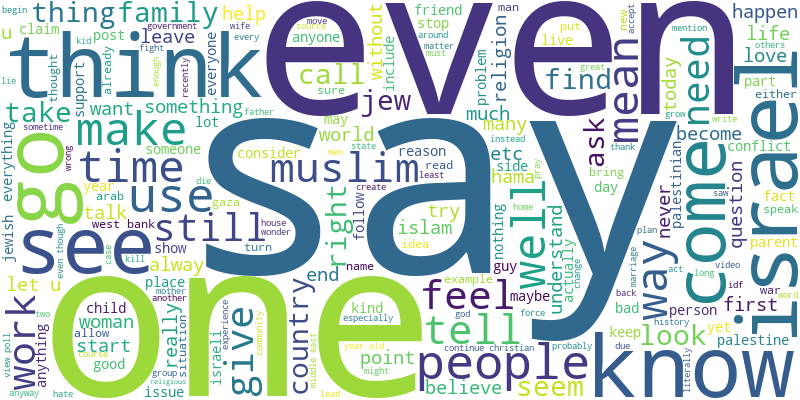

In [25]:
text_data = ' '.join(df['text'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text_data)

wordcloud.to_image()

In [26]:
tokenized_texts = df['text'].apply(lambda x: x.split())

In [27]:
tokenized_texts

0        [message, live, verify, many, scammer, try, fool]
1        [salaam, everyone, f, currently, go, divorce, ...
2        [quran, saw, verse, case, say, happy, come, sa...
3        [holocaust, book, family, jewish, hungarian, d...
4        [shalom, friend, baal, teshuva, many, tattoo, ...
                               ...                        
92665    [may, silly, question, live, canada, friend, s...
92666    [salam, currently, speak, girl, purpose, marri...
92667    [every, month, politician, west, across, almos...
92668    [comment, post, wild, many, people, subreddit,...
92669    [previous, post, remove, mod, apparently, cont...
Name: text, Length: 92670, dtype: object

In [28]:
dictionary = Dictionary(tokenized_texts)

In [29]:
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

In [36]:
coherence_scores = []

In [37]:
for topic in range(1, 11):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=topic, passes=10, random_state=5805)
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

In [38]:
coherence_scores

[0.3476693000754619,
 0.5070021711537325,
 0.5243005664142573,
 0.49282408971612557,
 0.4910690528118281,
 0.4827493229388195,
 0.513204288171699,
 0.49860038768039566,
 0.4878813142608602,
 0.4985342784745037]

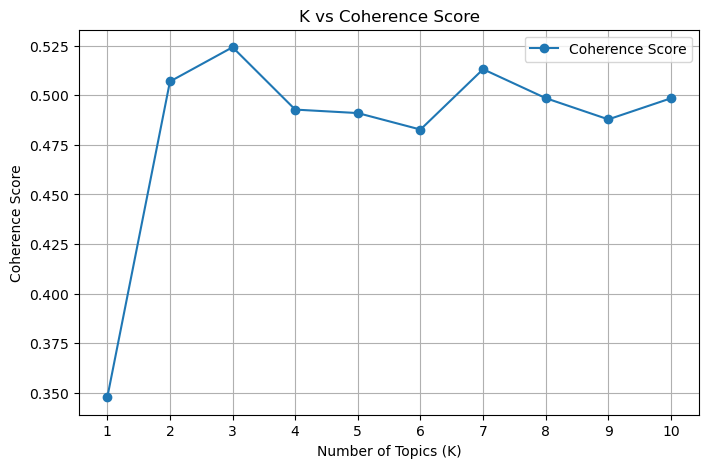

In [39]:
k_values = list(range(1, 11))

plt.figure(figsize=(8, 5))
plt.plot(k_values, coherence_scores, marker='o', linestyle='-', label='Coherence Score')
plt.title('K vs Coherence Score')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.xticks(k_values)
plt.grid()
plt.legend()
plt.show()

In [43]:
num_topics = lda_model.num_topics

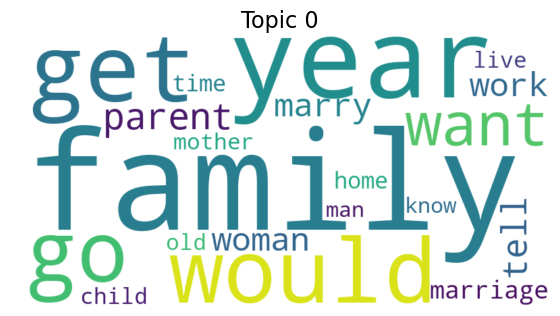

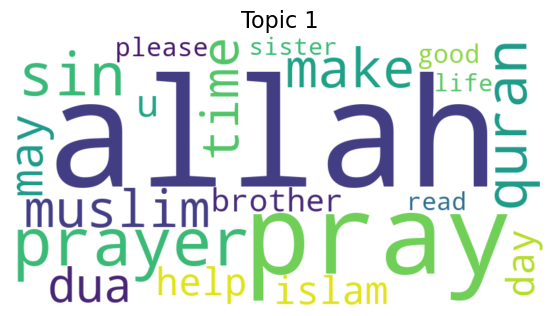

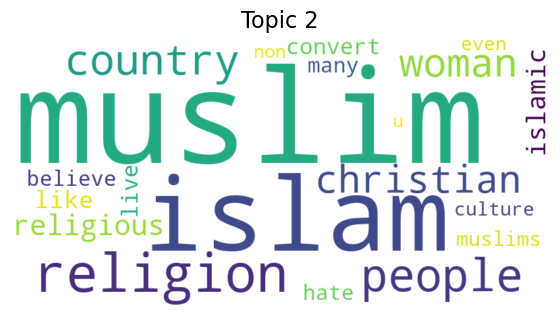

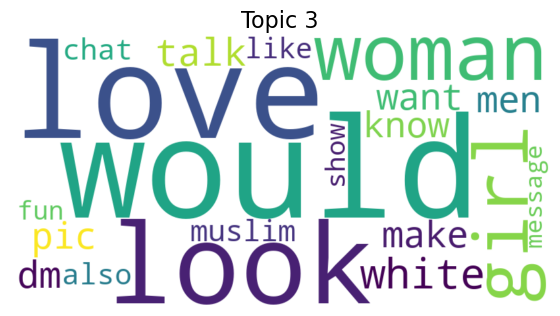

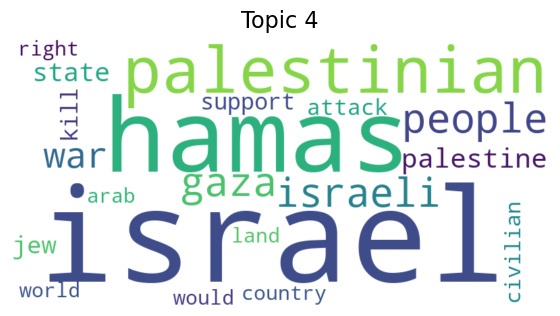

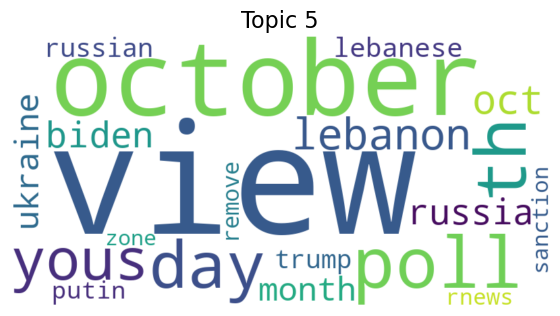

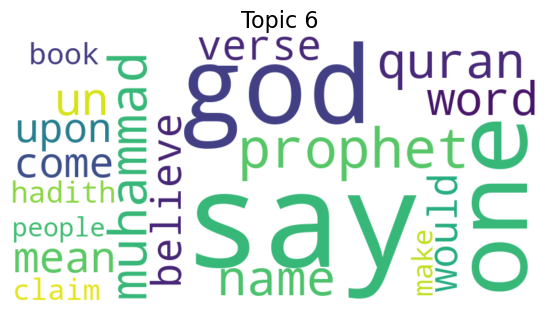

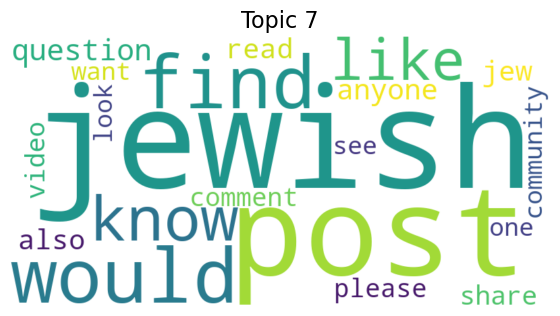

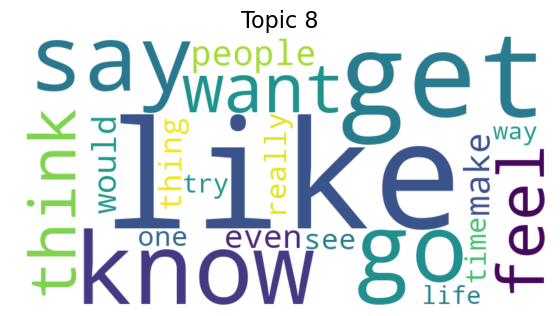

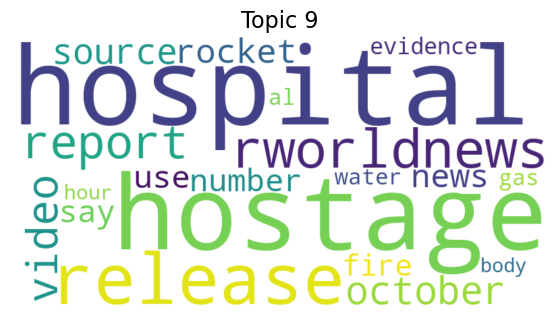

In [46]:
for topic_id in range(num_topics):
    words = lda_model.show_topic(topic_id, topn=20)
    word_freq = {word: weight for word, weight in words}

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.title(f"Topic {topic_id}", fontsize=16)
    plt.show()